# Notebook for calculating the Stress-Strain Curve

In this notebook, we will perform an MD simulation on a metal slab and resin model to derive the stress-strain curve.

## Initial Setup

First, let's install the necessary packages:

In [1]:
# ! pip install pfp-api-client
# ! pip install matlantis-features

## 1. Import packages, define functions

In [2]:
import os
import numpy as np
import random
import pathlib
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

from ase import Atoms
from ase import units
from ase.io import read, write, Trajectory
from ase.build import bulk, surface, sort
from ase.units import Pascal
from ase.visualize import view
from ase.spacegroup.symmetrize import FixSymmetry
from ase import neighborlist
from ase.constraints import FixAtoms

from rdkit import Chem
from rdkit.Chem import AllChem

from matlantis_features.utils.atoms_util import convert_atoms_to_upper
from matlantis_features.atoms import MatlantisAtoms
from matlantis_features.features.common.opt import LBFGSASEOptFeature, FireLBFGSASEOptFeature
from matlantis_features.features.md import ASEMDSystem, LangevinIntegrator, MDFeature, MDExtensionBase, NPTIntegrator
from matlantis_features.features.md.md_extensions import DeformScheduler
from matlantis_features.utils.calculators import get_calculator, pfp_estimator_fn

from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
estimator_fn = pfp_estimator_fn(model_version='v5.0.0', calc_mode='crystal_u0_plus_d3')

from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms
from pfcc_extras.structure.surface import makesurface

def density(atoms):
    vol = atoms.get_cell().volume *(1e-8)**3   # as cm3
    wt = sum(atoms.get_masses())    # as g/mol
    dens = wt / units.mol / vol
    return(dens)

class PrintCellShape(MDExtensionBase):
    def __init__(self, cell_log=None):
        self.cell_log = cell_log
    def __call__(self, system, integrator) -> None:
        cell_par = system.ase_atoms.get_cell_lengths_and_angles()
        istep = system.current_total_step
        print(f"Dyn step {istep:4d} a {cell_par[0]:3.2f} b {cell_par[1]:3.2f} c {cell_par[2]:3.2f} alpha {cell_par[3]:3.2f} beta {cell_par[4]:3.2f} gamma {cell_par[5]:3.2f} ")
        if self.cell_log is not None:
            self.cell_log.append(cell_par)
            
try:
    dir_path = pathlib.Path(__file__).parent
except:
    dir_path = pathlib.Path("").resolve()
    
input_dir = dir_path / "input"
output_dir = dir_path / "output"

## 2. Model Preparation

Create a metal slab model sandwiched between vacuum layers, with a resin inserted in between. By compressing the model along the z-axis, we can achieve the desired initial structure.

### 2-1. File Paths for I/O

In [3]:
# input file
# resin
resin_path = input_dir / "PEO.xyz"

# output file
# metal slab
metal_opt_path = output_dir / "model" / "slab_Fe.xyz"
# relaxed resin
resin_opt_path = output_dir / "model" / "resin_opt.xyz"
# metal slab and resin
slab_opt_path = output_dir / "model" / "slab.xyz"
# trajectory for high-T, compressing NPT simulation
npt1_path = output_dir / "md" / "npt1.traj"
# trajectory for room temperature NPT simulation
npt2_path = output_dir / "md" / "npt2.traj"
# tensile simulation
tensile_path = output_dir / "md" / "tensile.traj"
# figure of sscurve
ss_path = output_dir / "figure" / "ss.png"

# make directories
os.makedirs(output_dir / "model", exist_ok = True)
os.makedirs(output_dir / "md", exist_ok = True)
os.makedirs(output_dir / "figure", exist_ok = True)

### 2-2. Generate Metal Slab Model with Vacuum Layer

In [4]:
# relax of the bulk structure
print("Relaxation of bulk structure")
blk = bulk("Fe", "bcc")
blk.set_constraint([FixSymmetry(blk)])
opt = LBFGSASEOptFeature(n_run = 10000, fmax = 0.01, filter=True,
                         show_progress_bar=True, estimator_fn = estimator_fn)
result_opt = opt(blk)

# generate a slab model with a vacuum layer
vacuum = 500
slab = result_opt.atoms.ase_atoms.copy()
slab.set_constraint([])
# slab.set_constraint()
slab = makesurface(slab, miller_indices=(1,0,0), layers=10, rep=[8,8,1], vacuum=vacuum)

Relaxation of bulk structure


  0%|          | 0/10001 [00:00<?, ?it/s]

In [5]:
# shift by the half width of layers
atoms = slab.copy()
# Sort atoms by their z-coordinate
z_coordinates = [atom.position[2] for atom in atoms]
unique_layers = np.unique(np.round(z_coordinates, decimals=3))
layer_z_value = unique_layers[int(len(unique_layers) / 2)]
atoms_in_layer = [atom for atom in slab if np.round(atom.position[2], decimals=3) == layer_z_value]
z_coor = atoms_in_layer[0].position[2]
slab_2 = slab.copy()
slab_2.positions += [0,0,-z_coor]
slab_2.wrap()

# relaxation of surface structure
print("Relaxation of surface structure")
indices = [atom.index for atom in slab_2 if atom.position[2] <= 3]  # fix below 3A
slab_2.set_constraint(FixAtoms(indices))
result_opt_2 = opt(slab_2)
os.makedirs("output", exist_ok=True)
write(metal_opt_path, result_opt_2.atoms.ase_atoms, format='extxyz')

# visualization
v = view_ngl(result_opt_2.atoms.ase_atoms, representations=["ball+stick"])
v.view.control.spin([1,0,0], np.deg2rad(-90))
display(v)

Relaxation of surface structure


  0%|          | 0/10001 [00:00<?, ?it/s]

### 2-3. Insert Resin

In [6]:
atoms_organic = read(resin_path)

print("Relaxation of resin")
opt = LBFGSASEOptFeature(n_run = 10000, fmax = 0.01, filter=False,
                         show_progress_bar=True, estimator_fn = estimator_fn)
result_opt_organic = opt(atoms_organic)
write(resin_opt_path, result_opt_organic.atoms.ase_atoms, format='xyz')

view_ngl(result_opt_organic.atoms.ase_atoms)

Relaxation of resin


  0%|          | 0/10001 [00:00<?, ?it/s]

In [7]:
# generate a vacuum cell same with the vacuum laer
empty_cell = slab_2.copy()
slab_height = empty_cell.cell.cellpar()[2] - vacuum
slabatoms = len(empty_cell)
cellsize = empty_cell.cell.cellpar()[:3]
cellsize[2] = vacuum

vacuum_cell = Atoms(symbols="", 
                  pbc=True, 
                  cell=cellsize)

NoAtoms0=len(atoms_organic)

# confirm the density and number of atoms packing molecule
target_density = 0.10 # unit = g/cm3
sum_mass = atoms_organic.get_masses().sum()
sum_atoms = len(atoms_organic)
vac_vol = vacuum_cell.get_volume()*(1e-8)**3 # as cm3
d0 = sum_mass / units.mol / vac_vol # density estimation packing molecules
mlp = int(np.floor(target_density / d0)) # estimate how many molecules are packed
t_atoms = NoAtoms0 * mlp + slabatoms
print ("liquid phase initial density =", np.round(d0*mlp, 3), "g/cm3")
print ("slab + resin atoms =", t_atoms)

# fill resin in the vacuum layer
target_atoms = t_atoms    
vac_vol = empty_cell.get_volume()*(1e-8)**3 # as cm3

filled_cell = empty_cell.copy()
No_atoms, n = 0, 0
while No_atoms < target_atoms:
    # determine the posiiton of inserted molecule randomly
    ranx = random.uniform(0,1)
    rany = random.uniform(0,1)
    ranz = random.uniform(0.04,0.96)                           # remove the range of slab
    xyz_position=np.matmul([ranx,rany,ranz], filled_cell.cell)
    # determine the rotational angle of molecule
    phi, theta, psi = Rotation.random().as_euler('zxz', degrees=True)
    
    # translation and rotation of molecule
    # molNo = n
    # m = mol_list[molNo]
    m = result_opt_organic.atoms.ase_atoms
    m1 = m.copy()
    m1.euler_rotate(phi=phi, theta=theta, psi=psi)
    m1.positions += xyz_position
    
    # insert molecule if the maximum force is below a threathold
    Fcheck = filled_cell + m1
    Fcheck.calc = get_calculator(estimator_fn)
    if (np.sum(Fcheck.get_forces()**2, axis=1)**0.5).max() <= 100:
        filled_cell = filled_cell + m1
        n+=1
        No_atoms = len(filled_cell)
        print("No_of_atoms =", No_atoms, ", including slab", len(empty_cell), "atoms")    
    else:
        n+=0

assert mlp == n

liquid phase initial density = 0.093 g/cm3
slab + resin atoms = 2336
No_of_atoms = 852 , including slab 640 atoms
No_of_atoms = 1064 , including slab 640 atoms
No_of_atoms = 1276 , including slab 640 atoms
No_of_atoms = 1488 , including slab 640 atoms
No_of_atoms = 1700 , including slab 640 atoms
No_of_atoms = 1912 , including slab 640 atoms
No_of_atoms = 2124 , including slab 640 atoms
No_of_atoms = 2336 , including slab 640 atoms


In [8]:
# optimize the filled structure
indices = [atom.index for atom in filled_cell if atom.position[2] <= 3.0]
c = FixAtoms(indices)
filled_cell.set_constraint(c)

opt = LBFGSASEOptFeature(n_run = 10000, fmax = 0.1, filter=True,
                         show_progress_bar=True, estimator_fn = estimator_fn)
result_opt_filled = opt(filled_cell)

# save the optimized structure
result_opt_filled.atoms.ase_atoms.set_initial_charges()
write(slab_opt_path, result_opt_filled.atoms.ase_atoms, format='extxyz')

# visualization
v = view_ngl(result_opt_filled.atoms.ase_atoms, representations=["ball+stick"])
v.view.control.spin([1,0,0], np.deg2rad(-90))
display(v)

  0%|          | 0/10001 [00:00<?, ?it/s]

/home/jovyan/.py38/lib/python3.8/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


### 2-4. Compression Along the Z-Axis

In [9]:
ase_atoms =read(slab_opt_path)
indices = [atom.index for atom in ase_atoms if atom.position[2] <= 3]
c = FixAtoms(indices)
ase_atoms.set_constraint(c)

atoms = MatlantisAtoms.from_ase_atoms(ase_atoms)
atoms.rotate_atoms_to_upper()

# NPT
t_step = 1     # as fs
press = 0.000101325 * 1000 # as GPa 1000times larger than atomspheric pressure
temperature = 473.0

system = ASEMDSystem(atoms)
system.init_temperature(temperature)

integrator = NPTIntegrator(timestep=t_step,
                           temperature=temperature,
                           pressure=press * units.GPa,
                           ttime=20*units.fs,
                           pfactor=2e6*units.GPa*(units.fs**2),
                           mask=np.array([[0,0,0], [0,0,0], [0,0,1]]))

info = PrintCellShape()

md = MDFeature(integrator, n_run=75000, traj_file_name=npt1_path,
               traj_freq=100, estimator_fn = estimator_fn)

md(system, extensions=[(info, 1000)])

The MD trajectory will be saved at /home/jovyan/work/2023/sscurve/contrib/output_en/md/npt1.traj.
Note: The max disk size of /home/jovyan is about 99G.
/home/jovyan/.py38/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


Dyn step    0 a 19.45 b 19.45 c 517.89 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 1000 a 19.45 b 19.45 c 506.59 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 2000 a 19.45 b 19.45 c 473.00 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 3000 a 19.45 b 19.45 c 423.41 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 4000 a 19.45 b 19.45 c 365.13 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 5000 a 19.45 b 19.45 c 305.13 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 6000 a 19.45 b 19.45 c 248.63 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 7000 a 19.45 b 19.45 c 198.45 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 8000 a 19.45 b 19.45 c 156.26 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 9000 a 19.45 b 19.45 c 122.12 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 10000 a 19.45 b 19.45 c 96.55 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 11000 a 19.45 b 19.45 c 80.15 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 12000 a 19.45 b 19.45 c 69.31 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 130

MDFeatureResult(traj_path=PosixPath('/home/jovyan/work/2023/sscurve/contrib/output_en/md/npt1.traj'), checkpoint_path='/tmp/matlantis_rp0s3d_m/tmpk31fbw2w.chkp', temp_dir=<TemporaryDirectory '/tmp/matlantis_rp0s3d_m'>)

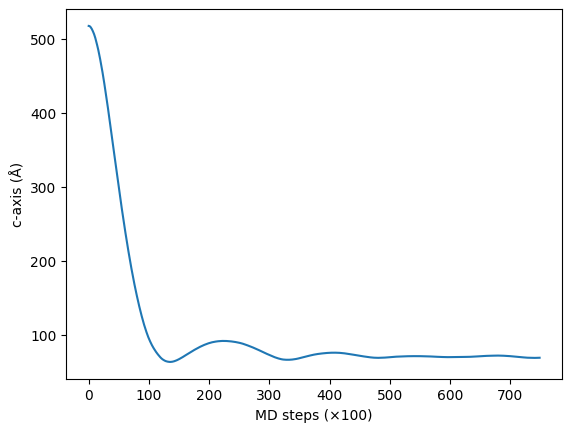

In [10]:
# check the change of the length of c-axis and final structure 
traj = read(npt1_path, "::1")

c_length = [atoms.cell.cellpar()[2] for atoms in traj]
plt.plot(c_length)
plt.ylabel("c-axis (Å)")
plt.xlabel("MD steps (×100)")
plt.show()

v = view_ngl(traj[-1], representations=["ball+stick"])
v.view.control.spin([1,0,0], np.deg2rad(-90))
display(v)

## 3. Equilibration at Room Temperature

In [11]:
ase_atoms = read(npt1_path, "-1")
atoms = MatlantisAtoms.from_ase_atoms(ase_atoms)
atoms.rotate_atoms_to_upper()

# NPT
t_step = 1     # as fs
temperature = 300.0

system = ASEMDSystem(atoms)
system.init_temperature(temperature)

integrator = NPTIntegrator(timestep=1.0,
                           temperature=temperature,
                           pressure=units.bar,
                           ttime=20*units.fs,
                           pfactor=2e6*units.GPa*(units.fs**2),
                           mask=np.array([[0,0,0], [0,0,0], [0,0,1]]))

info = PrintCellShape()

md = MDFeature(integrator, n_run=50000, traj_file_name=npt2_path,
               traj_freq=100, estimator_fn = estimator_fn)
md(system, extensions=[(info, 1000)])

The MD trajectory will be saved at /home/jovyan/work/2023/sscurve/contrib/output_en/md/npt2.traj.
Note: The max disk size of /home/jovyan is about 99G.
/home/jovyan/.py38/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


Dyn step    0 a 19.45 b 19.45 c 68.69 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 1000 a 19.45 b 19.45 c 68.62 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 2000 a 19.45 b 19.45 c 68.59 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 3000 a 19.45 b 19.45 c 68.65 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 4000 a 19.45 b 19.45 c 68.20 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 5000 a 19.45 b 19.45 c 68.60 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 6000 a 19.45 b 19.45 c 68.88 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 7000 a 19.45 b 19.45 c 68.84 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 8000 a 19.45 b 19.45 c 68.06 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 9000 a 19.45 b 19.45 c 67.47 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 10000 a 19.45 b 19.45 c 67.90 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 11000 a 19.45 b 19.45 c 69.00 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 12000 a 19.45 b 19.45 c 69.32 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 13000 a 19.45

MDFeatureResult(traj_path=PosixPath('/home/jovyan/work/2023/sscurve/contrib/output_en/md/npt2.traj'), checkpoint_path='/tmp/matlantis_jrh5t2pj/tmpmpag1bc8.chkp', temp_dir=<TemporaryDirectory '/tmp/matlantis_jrh5t2pj'>)

## 4. Tensile Simulation

In [12]:
ase_atoms = read(npt2_path, "-1")
atoms = MatlantisAtoms.from_ase_atoms(ase_atoms)
atoms.rotate_atoms_to_upper()

system = ASEMDSystem(atoms)
system.init_temperature(temperature)

# extend the unit cell by 150% along with z-axis
latt = np.array(system.ase_atoms.cell)
latt[2,2] = latt[2,2]*1.5

# 引っ張り計算。
integrator = LangevinIntegrator(timestep=1.0, temperature=300.0)

info = PrintCellShape()
deform = DeformScheduler(latt, 50000)

md = MDFeature(integrator, n_run=50000, traj_file_name=tensile_path,
               traj_freq=100, estimator_fn = estimator_fn)
md(system, extensions=[(info, 1000), (deform, 1)])

The MD trajectory will be saved at /home/jovyan/work/2023/sscurve/contrib/output_en/md/tensile.traj.
Note: The max disk size of /home/jovyan is about 99G.
/home/jovyan/.py38/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


Dyn step    0 a 19.45 b 19.45 c 67.36 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 1000 a 19.45 b 19.45 c 68.03 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 2000 a 19.45 b 19.45 c 68.70 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 3000 a 19.45 b 19.45 c 69.38 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 4000 a 19.45 b 19.45 c 70.05 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 5000 a 19.45 b 19.45 c 70.73 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 6000 a 19.45 b 19.45 c 71.40 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 7000 a 19.45 b 19.45 c 72.07 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 8000 a 19.45 b 19.45 c 72.75 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 9000 a 19.45 b 19.45 c 73.42 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 10000 a 19.45 b 19.45 c 74.09 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 11000 a 19.45 b 19.45 c 74.77 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 12000 a 19.45 b 19.45 c 75.44 alpha 90.00 beta 90.00 gamma 109.49 
Dyn step 13000 a 19.45

MDFeatureResult(traj_path=PosixPath('/home/jovyan/work/2023/sscurve/contrib/output_en/md/tensile.traj'), checkpoint_path='/tmp/matlantis_lsjm_e6l/tmpy1ima6ld.chkp', temp_dir=<TemporaryDirectory '/tmp/matlantis_lsjm_e6l'>)

## 5. Plotting the Stress-Strain Curve

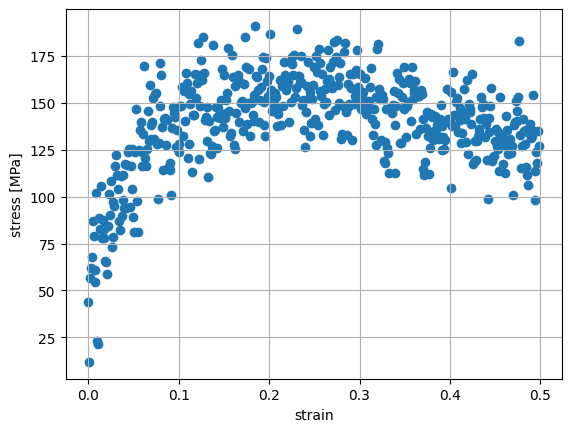

In [13]:
traj = Trajectory(tensile_path)

stress = []
zlen = []
for i in traj:
    stress.append(i.get_stress()[2])
    zlen.append(i.cell.cellpar()[2])
zlen = np.array(zlen)
strain = (zlen-zlen[0])/zlen[0]

os.makedirs("output/figure", exist_ok = True)

plt.scatter(strain,np.array(stress)/Pascal/10e6)
plt.xlabel("strain")
plt.ylabel("stress [MPa]")
plt.grid(True)
plt.savefig(ss_path)